# Reinforcement Learning to play Dino Run
I used reinfrocement learning to teach the model to control the dino agent from the Chrome's offline game, Dino Run, by detecting and jumping over obstacles. This project is inspired from the DeepMind's paper '[Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)' where the team tranied the model using reinforcement learning to play 7 Atari 2006 games


### This document mainly deals with code implementation of the project. To know more about the background and steps performed please refer my blog:<br> https://medium.com/acing-ai/how-i-build-an-ai-to-play-dino-run-e37f37bdf153

### All the code in this as well as any other document discussing this work is released under the MIT License https://opensource.org/licenses/MIT
### The writing in this as well as any other document linked with this project is released under The Creative Commons Attribution 3.0 License https://creativecommons.org/licenses/by/3.0/us/ 




### Dependencies
* Python 3.6
* Selenium
* OpenCV
* PIL
* Keras
* Chromium driver for Selenium

### Modifying the original game for faster learning on CPU only system
Original game is available as a part of Chromium's open source repository. We can modify the game under the BSD-style license(can be found in repository). Below are the configurations modified as a part of this project<br>
* ACCELERATION = 0 # speed of the agent stays constant throughout the gameplay
* TYPES OF OBSTACLES limit to 1, we have trained the model only for a single type of obstacle(cacuts) with fixed size
* GAME START TIME was reduced to around 400ms, originally each game would take 1 sec to start but reduced for faster learning
* JUMP VELOCITY was increased because when the dino is mid-air, there are no actions or features to be learned, so stays mid air for shorter period of time
* GAME OVER PANEL was removed as it is not a feautre to be learned, selenium interface is detect game over and restart
* HIGH SCORE PANEL was removed as we are not maintaning high score on the game panel
<br>


### Selnium as interface between the model and game
As the game is browser based and the model is built on python, we need some interface through which we can observe the game environment and send actions to agent to play the game. We use <strong>Selenium</strong> to control the browser and send actions to the agent. 


### OpenCV & PIL for Image capturing and pre-processing
To acquire the video of game play I have used PIL and openCV to capture & process sequential screenshot from the screen and then fed through the model for traning as well as playing

#### Imports

In [1]:
import numpy as np
from PIL import ImageGrab #grabbing image
from PIL import Image
import cv2 #opencv
import io
import time
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (30, 30)
import seaborn as sns
import pandas as pd
import numpy as np
from random import randint
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
#keras imports
%matplotlib inline 
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
from keras.callbacks import TensorBoard
from collections import deque
import random
import pickle
import json
import math

#### Path variables
We have two external dependencies
* The modifed version of the game(web app) 
* The executable of chromewebdriver for selenium. This is not included in the repo as it is system dependent, it needs to placed one level above the project folder
* path to log files

In [2]:
#path variables
game_url = "C:/Users/sazga/OneDrive - Durham College/GitHub/dino_js_1/Dino_game_manual/Dinosaur-Chrome-Game-master/Dinosaur-Chrome-Game-master/index.html"
chrome_driver_path = "C:/Users/sazga/OneDrive - Durham College/GitHub/Paperspace/DinoRunTutorial/chromedriver_win32/chromedriver.exe"
loss_file_path = "./objects/loss_df.csv"
actions_file_path = "./objects/actions_df.csv"
scores_file_path = "./objects/scores_df.csv"

### Game Module
This is the main module that implements interfacing between the python and browser-javascript using selenium


In [3]:
'''
* Game class: Selenium interfacing between the python and browser
* __init__():  Launch the broswer window using the attributes in chrome_options
* get_crashed() : return true if the agent as crashed on an obstacles. Gets javascript variable from game decribing the state
* get_playing(): true if game in progress, false is crashed or paused
* restart() : sends a signal to browser-javascript to restart the game
* press_up(): sends a single to press up get to the browser
* get_score(): gets current game score from javascript variables.
* pause(): pause the game
* resume(): resume a paused game if not crashed
* end(): close the browser and end the game
'''
class Game:
    def __init__(self,custom_config=False):
        chrome_options = Options()
        chrome_options.add_argument("disable-infobars")
        self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
        self._driver.set_window_position(x=-10,y=0)
        self._driver.set_window_size(200, 300)
        self._driver.get(os.path.abspath(game_url))
        #modifying game before trainNetworkining
        if custom_config:
            self._driver.execute_script("Game.config.ACCELERATION=0")
    def get_crashed(self):
        return self._driver.execute_script("return Game.instance_.finished")
    def get_playing(self):
        return self._driver.execute_script("return Game.instance_.running")
    def restart(self):
        self._driver.execute_script("Game.instance_.restart()")
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
        #time.sleep(0.25)# no actions are possible 
                        # for 0.25 sec after game starts, 
                        # skip learning at this time and make the model wait
    def press_up(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    def get_score(self):
        
        score = self._driver.execute_script("return Game.instance_.offset") 
#         print(score_array)
#         score = ''.join(score_array) # the javascript object is of type array with score in the formate[1,0,0] which is 100.
        return math.floor(int(score)*0.1)
#     def pause(self):
#         return self._driver.execute_script("return Game.instance_.stop()")
#     def resume(self):
#         return self._driver.execute_script("return Game.instance_.play()")
    def end(self):
        self._driver.close()

In [4]:
Game().get_score()

C:\Users\sazga\AppData\Local\Temp/ipykernel_20204/932615885.py:17: DeprecationWarning: use options instead of chrome_options
  self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)


0

### Agent module
This model represent the agent (Dino) which the model controls for playing. 

In [5]:
class DinoAgent:
    def __init__(self,game): #takes game as input for taking actions
        self._game = game; 
        self.jump(); #to start the game, we need to jump once
        time.sleep(.5) # no action can be performed for the first time when game starts
    def is_running(self):
        return self._game.get_playing()
    def is_crashed(self):
        return self._game.get_crashed()
    def jump(self):
        self._game.press_up()
    def duck(self):
        self._game.press_down()

### Game state module
Game state helps to get the current state of the game environment as well as the agent.<br>
Actions are performed by this model before getting a new state

In [6]:
class Game_sate:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game
        self._display = show_img() #display the processed image on screen using openCV, implemented using python coroutine 
        self._display.__next__() # initiliaze the display coroutine 
    def get_state(self,actions):
        actions_df.loc[len(actions_df)] = actions[1] # storing actions in a dataframe
        score = self._game.get_score() 
        reward = 0.1*score/10 # dynamic reward calculation
        is_over = False #game over
        if actions[1] == 1:
            self._agent.jump()
            reward = 0.1*score/11
        image = grab_screen() 
        self._display.send(image) #display the image on screen

        if self._agent.is_crashed():
            scores_df.loc[len(loss_df)] = score # log the score when game is over
            self._game.restart()
            reward = -11/score
            is_over = True
        return image, reward, is_over #return the Experience tuple

### Utilities

* save_obj() and load_obj(): As the training can takes a week, we will need to presever the state of the game in the file system. We dump required objects using pickle module of python
* grab_screen() : using PIL library to capture the screen and bbox for locating the region of interest<sup>+</sup>
* process_img(): performing necessary image transformations before sending it to the model<sup>+</sup><br>
* show_img(): coroutine implementation to observe the images that are being sent to the model <sup>*</sup><br>

<sup>+</sup>The image processing modules were inspired from Harrison Sentdex's github which is licensed under the GNU GENERAL PUBLIC LICENSE http://www.gnu.org/licenses/gpl.html<br>
<sup>*</sup>Coroutine implementation in the code below belongs to Ben Meijering and is licensed under the MIT License https://opensource.org/licenses/MIT

In [7]:
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f: #dump files into objects folder
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def grab_screen(_driver = None):
    screen =  np.array(ImageGrab.grab(bbox=(40,180,440,400))) #bbox = region of interset on the entire screen
    image = process_img(screen)#processing image as required
    return image

def process_img(image):
    #game is already in grey scale canvas, canny to get only edges and reduce unwanted objects(clouds)
    image = cv2.resize(image, (0,0), fx = 0.15, fy = 0.10) # resale image dimensions
    image = image[2:38,10:50] #img[y:y+h, x:x+w] #crop out the dino agent from the frame
    image = cv2.Canny(image, threshold1 = 100, threshold2 = 200) #apply the canny edge detection
    return  image
def show_img(graphs = False):
    """
    Show images in new window
    """
    while True:
        screen = (yield)
        window_title = "logs" if graphs else "game_play"
        cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)        
        imS = cv2.resize(screen, (800, 400)) 
        cv2.imshow(window_title, screen)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            cv2.destroyAllWindows()
            break

### Intialize log structures

In [8]:
#Intialize log structures from file if exists else create new
loss_df = pd.read_csv(loss_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns =['loss'])
scores_df = pd.read_csv(scores_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns = ['scores'])
actions_df = pd.read_csv(actions_file_path) if os.path.isfile(actions_file_path) else pd.DataFrame(columns = ['actions'])

In [9]:
# training variables saved as checkpoints to filesystem to resume training from the same step
def init_cache():
    """initial variable caching, done only once"""
    save_obj(INITIAL_EPSILON,"epsilon")
    t = 0
    save_obj(t,"time")
    D = deque()
    save_obj(D,"D")

In [10]:
# init_cache()

#### Module parameters

In [11]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.99 # decay rate of past observations original 0.99
OBSERVATION = 50000. # timesteps to observe before training
EXPLORE = 100000  # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4
img_rows , img_cols = 40,20
img_channels = 4 #We stack 4 frames

### Building the model

* The input to our model is a tensor: 4 stacked images of dimension of 40x20 = 40x20x4 <br>
* Each action has it's own output (2 outputs) : The q_value for each action

The model architecture is referred from the DeepMind paper https://arxiv.org/abs/1312.5602 <br>
The implementation is inspired from _Using Keras and Deep Q-Network to Play FlappyBird_ https://github.com/yanpanlau/Keras-FlappyBird and available publicly for use

In [12]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4, 4), padding='same',input_shape=(img_cols,img_rows,img_channels)))  #20*40*4
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

### Mode Architecture

In [13]:
buildmodel().summary()

Now we build the model
We finish building the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 10, 32)         8224      
_________________________________________________________________
activation (Activation)      (None, 5, 10, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 5, 64)          32832     
_________________________________________________________________
activation_1 (Activation)    (None, 3, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 5, 64)          36928     
_________________________________________________________________
activation_2 (Activation)    (None, 3, 5, 64)          0         
_________________________________________________________________
flat

### Main Training Module
#### Alogrithm for Deep QNN

##### The Model code was inspired from the Flappy Bird implementation of reinforcement learning in Pygame.<br>
#### The original content belongs to [Ben Lau](https://github.com/yanpanlau/Keras-FlappyBird) and is publicly availabe on github

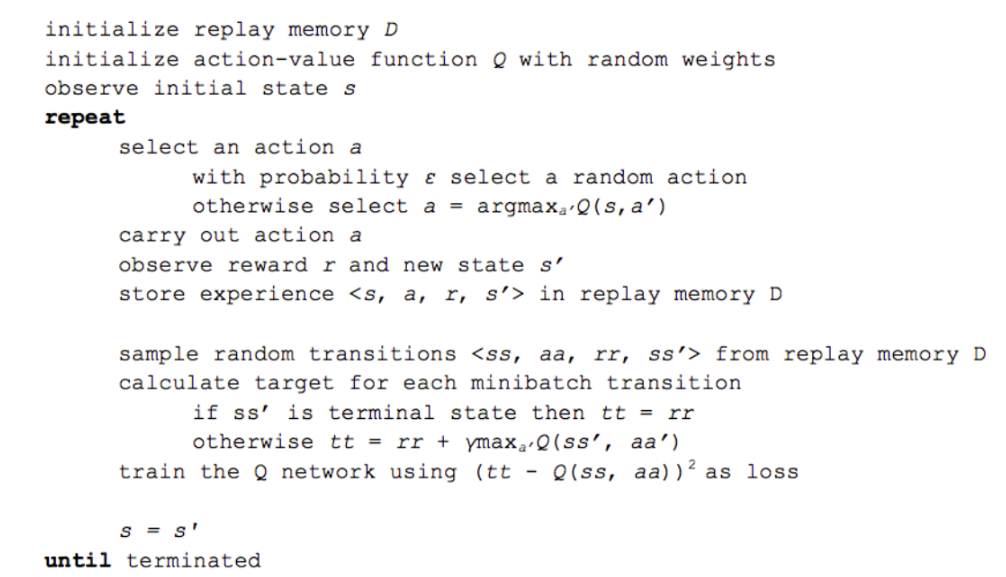

In [14]:
''' 
main training module
Parameters:
* model => Keras Model to be trained
* game_state => Game State module with access to game environment and dino
* observe => flag to indicate wherther the model is to be trained(weight updates), else just play
'''
def trainNetwork(model,game_state,observe=False):
    last_time = time.time()
    # store the previous observations in replay memory
    D = load_obj("D") #load from file system
    # get the first state by doing nothing
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] =1 #0 => do nothing,
                     #1=> jump
    
    x_t, r_0, terminal = game_state.get_state(do_nothing) # get next step after performing the action
    

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2) # stack 4 images to create placeholder input
    

    
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*20*40*4
    
    initial_state = s_t 

    if observe :
        OBSERVE = 10 #999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon") 
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

    t = load_obj("time") # resume from the previous time step stored in file system
    while (True): #endless running
        
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0 #reward at 4
        a_t = np.zeros([ACTIONS]) # action at t
        
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0: #parameter to skip frames for actions
            if  random.random() <= epsilon: #randomly explore an action
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[0] = 1
            else: # predict the output
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)         # chosing index with maximum q value
                action_index = max_Q 
                a_t[action_index] = 1        # o=> do nothing, 1=> jump
                
        #We reduced the epsilon (exploration parameter) gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE 

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = game_state.get_state(a_t)
        print('loop took {} seconds'.format(time.time()-last_time)) # helpful for measuring frame rate
        last_time = time.time()
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x20x40x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # append the new image to input stack and remove the first one
        
        
        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE: 
            
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]    # 4D stack of images
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]   #reward at state_t due to action_t
                state_t1 = minibatch[i][3]   #next state
                terminal = minibatch[i][4]   #wheather the agent died or survided due the action
                

                inputs[i:i + 1] = state_t    

                targets[i] = model.predict(state_t)  # predicted q values
                Q_sa = model.predict(state_t1)      #predict q values for next step
                
                if terminal:
                    targets[i, action_t] = reward_t # if terminated, only equals reward
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
        else:
            # artificial time delay as training done with this delay
            time.sleep(0.12)
        s_t = initial_state if terminal else s_t1 #reset game to initial frame if terminate
        t = t + 1
        
        # save progress every 1000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            
            model.save_weights("model_final.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv",index=False)
            scores_df.to_csv("./objects/scores_df.csv",index=False)
            actions_df.to_csv("./objects/actions_df.csv",index=False)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state,             "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,             "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")


### main function
* initialize game module, launches browser
* initialize the agent module
* initialize the game state module
* build the keras model
* start the training loop

In [15]:
def playGame(observe=False):
    game = Game()
    dino = DinoAgent(game)
    game_state = Game_sate(dino,game)
    model = buildmodel()
    try:
        trainNetwork(model,game_state,observe=observe)
    except StopIteration:
        game.end()

In [16]:
playGame(observe=False);

C:\Users\sazga\AppData\Local\Temp/ipykernel_20204/932615885.py:17: DeprecationWarning: use options instead of chrome_options
  self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)


Now we build the model
We finish building the model
loop took 0.3928368091583252 seconds
TIMESTEP 2001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.268146276473999 seconds
TIMESTEP 2002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2647225856781006 seconds
TIMESTEP 2003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.279327392578125 seconds
TIMESTEP 2004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26453733444213867 seconds
TIMESTEP 2005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.27907252311706543 seconds
TIMESTEP 2006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.29306721687316895 seconds
TIMESTEP 2007 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2930612564086914 seconds
TIMESTEP 2008 / STATE observ

TIMESTEP 2064 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2536444664001465 seconds
TIMESTEP 2065 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23421645164489746 seconds
TIMESTEP 2066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26082944869995117 seconds
TIMESTEP 2067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26206421852111816 seconds
TIMESTEP 2068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.25234436988830566 seconds
TIMESTEP 2069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.25110888481140137 seconds
TIMESTEP 2070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26615118980407715 seconds
TIMESTEP 2071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26025676727

loop took 0.24744319915771484 seconds
TIMESTEP 2128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26540231704711914 seconds
TIMESTEP 2129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26238059997558594 seconds
TIMESTEP 2130 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26068544387817383 seconds
TIMESTEP 2131 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24467825889587402 seconds
TIMESTEP 2132 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23533940315246582 seconds
TIMESTEP 2133 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24593305587768555 seconds
TIMESTEP 2134 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.21612262725830078 seconds
TIMESTEP 2135 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_M

TIMESTEP 2191 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.27936458587646484 seconds
TIMESTEP 2192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26307177543640137 seconds
TIMESTEP 2193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2506880760192871 seconds
TIMESTEP 2194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.20290899276733398 seconds
TIMESTEP 2195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26064372062683105 seconds
TIMESTEP 2196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.28105592727661133 seconds
TIMESTEP 2197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2489776611328125 seconds
TIMESTEP 2198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 

TIMESTEP 2253 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24587559700012207 seconds
TIMESTEP 2254 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.22874927520751953 seconds
TIMESTEP 2255 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2639327049255371 seconds
TIMESTEP 2256 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23644518852233887 seconds
TIMESTEP 2257 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23302745819091797 seconds
TIMESTEP 2258 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23403310775756836 seconds
TIMESTEP 2259 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.201507568359375 seconds
TIMESTEP 2260 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 /

TIMESTEP 2317 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.32595252990722656 seconds
TIMESTEP 2318 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.3250744342803955 seconds
TIMESTEP 2319 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.3210728168487549 seconds
TIMESTEP 2320 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2771000862121582 seconds
TIMESTEP 2321 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24649715423583984 seconds
TIMESTEP 2322 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21585798263549805 seconds
TIMESTEP 2323 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2046523094177246 seconds
TIMESTEP 2324 / STATE observe / EPSILON 0.1 / A

TIMESTEP 2381 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.22988462448120117 seconds
TIMESTEP 2382 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24444174766540527 seconds
TIMESTEP 2383 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24603700637817383 seconds
TIMESTEP 2384 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23491358757019043 seconds
TIMESTEP 2385 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.27603697776794434 seconds
TIMESTEP 2386 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2617504596710205 seconds
TIMESTEP 2387 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23230981826782227 seconds
TIMESTEP 2388 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action

loop took 0.3248586654663086 seconds
TIMESTEP 2445 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2588472366333008 seconds
TIMESTEP 2446 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.4854412078857422 seconds
TIMESTEP 2447 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2786445617675781 seconds
TIMESTEP 2448 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26546287536621094 seconds
TIMESTEP 2449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2787618637084961 seconds
TIMESTEP 2450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23303651809692383 seconds
TIMESTEP 2451 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.22901701927185059 seconds
TIMESTEP 2452 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0

loop took 0.2165083885192871 seconds
TIMESTEP 2509 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24564099311828613 seconds
TIMESTEP 2510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2647721767425537 seconds
TIMESTEP 2511 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24787139892578125 seconds
TIMESTEP 2512 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2612571716308594 seconds
TIMESTEP 2513 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.25008153915405273 seconds
TIMESTEP 2514 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2519552707672119 seconds
TIMESTEP 2515 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.27390003204345703 seconds
TIMESTEP 2516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  

loop took 0.2460634708404541 seconds
TIMESTEP 2573 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.235978364944458 seconds
TIMESTEP 2574 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24712729454040527 seconds
TIMESTEP 2575 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2344377040863037 seconds
TIMESTEP 2576 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.22876906394958496 seconds
TIMESTEP 2577 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.20164966583251953 seconds
TIMESTEP 2578 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.20125770568847656 seconds
TIMESTEP 2579 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24485278129577637 seconds
TIMESTEP 

loop took 0.21747040748596191 seconds
TIMESTEP 2636 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24802517890930176 seconds
TIMESTEP 2637 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23282861709594727 seconds
TIMESTEP 2638 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23659610748291016 seconds
TIMESTEP 2639 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23517656326293945 seconds
TIMESTEP 2640 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21434807777404785 seconds
TIMESTEP 2641 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24814581871032715 seconds
TIMESTEP 2642 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2319040298461914 seconds
TIMESTEP 2643 / STATE observe / EPSILON 

TIMESTEP 2698 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23395156860351562 seconds
TIMESTEP 2699 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24904298782348633 seconds
TIMESTEP 2700 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.20450305938720703 seconds
TIMESTEP 2701 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24424314498901367 seconds
TIMESTEP 2702 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26123523712158203 seconds
TIMESTEP 2703 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2438526153564453 seconds
TIMESTEP 2704 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24356579780578613 seconds
TIMESTEP 2705 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0

loop took 0.23407602310180664 seconds
TIMESTEP 2762 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23203468322753906 seconds
TIMESTEP 2763 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23474860191345215 seconds
TIMESTEP 2764 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.2206404209136963 seconds
TIMESTEP 2765 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.21878504753112793 seconds
TIMESTEP 2766 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23209714889526367 seconds
TIMESTEP 2767 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.23150253295898438 seconds
TIMESTEP 2768 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.22186684608459473 seconds
TIMESTEP 2769 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD 0.0 / Q_MA

TIMESTEP 2824 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.24692201614379883 seconds
TIMESTEP 2825 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.25881314277648926 seconds
TIMESTEP 2826 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.25045299530029297 seconds
TIMESTEP 2827 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26447272300720215 seconds
TIMESTEP 2828 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.25012874603271484 seconds
TIMESTEP 2829 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.278717041015625 seconds
TIMESTEP 2830 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.26255011558532715 seconds
TIMESTEP 2831 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD 0.0 / Q_MAX  0 / Loss  0
loop took 0.234729766845

loop took 0.2744722366333008 seconds
TIMESTEP 2887 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2975144386291504 seconds
TIMESTEP 2888 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29970884323120117 seconds
TIMESTEP 2889 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3262786865234375 seconds
TIMESTEP 2890 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.320404052734375 seconds
TIMESTEP 2891 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2769801616668701 seconds
TIMESTEP 2892 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2941477298736572 seconds
TIMESTEP 2893 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0

loop took 0.21573877334594727 seconds
TIMESTEP 2944 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29515767097473145 seconds
TIMESTEP 2945 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.300992488861084 seconds
TIMESTEP 2946 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2965538501739502 seconds
TIMESTEP 2947 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2941281795501709 seconds
TIMESTEP 2948 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27628135681152344 seconds
TIMESTEP 2949 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.4317350387573242 seconds
TIMESTEP 2950 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss 

loop took 0.28325390815734863 seconds
Now we save model
TIMESTEP 3000 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 4.804887771606445 seconds
TIMESTEP 3001 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3068091869354248 seconds
TIMESTEP 3002 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30061960220336914 seconds
TIMESTEP 3003 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30699729919433594 seconds
TIMESTEP 3004 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27146124839782715 seconds
TIMESTEP 3005 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29157161712646484 seconds
TIMESTEP 3006 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1392405063291139

loop took 0.27755212783813477 seconds
TIMESTEP 3057 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2778432369232178 seconds
TIMESTEP 3058 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27713847160339355 seconds
TIMESTEP 3059 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28367090225219727 seconds
TIMESTEP 3060 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27716517448425293 seconds
TIMESTEP 3061 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29421305656433105 seconds
TIMESTEP 3062 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30768775939941406 seconds
TIMESTEP 3063 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / L

loop took 0.2791156768798828 seconds
TIMESTEP 3113 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21929454803466797 seconds
TIMESTEP 3114 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2772669792175293 seconds
TIMESTEP 3115 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2770535945892334 seconds
TIMESTEP 3116 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27222156524658203 seconds
TIMESTEP 3117 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2963407039642334 seconds
TIMESTEP 3118 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2802431583404541 seconds
TIMESTEP 3119 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13

loop took 0.2762010097503662 seconds
TIMESTEP 3169 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2960691452026367 seconds
TIMESTEP 3170 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2495124340057373 seconds
TIMESTEP 3171 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.23278379440307617 seconds
TIMESTEP 3172 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2907099723815918 seconds
TIMESTEP 3173 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.23187899589538574 seconds
TIMESTEP 3174 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2789585590362549 seconds
T

TIMESTEP 3224 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29599881172180176 seconds
TIMESTEP 3225 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2828812599182129 seconds
TIMESTEP 3226 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.1973259449005127 seconds
TIMESTEP 3227 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27765345573425293 seconds
TIMESTEP 3228 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27846622467041016 seconds
TIMESTEP 3229 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2818901538848877 seconds
TIMESTEP 3230 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0

TIMESTEP 3280 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27904701232910156 seconds
TIMESTEP 3281 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28163671493530273 seconds
TIMESTEP 3282 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27394795417785645 seconds
TIMESTEP 3283 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2963376045227051 seconds
TIMESTEP 3284 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28092002868652344 seconds
TIMESTEP 3285 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2330331802368164 seconds
TIMESTEP 3286 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  

TIMESTEP 3336 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2956368923187256 seconds
TIMESTEP 3337 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2956571578979492 seconds
TIMESTEP 3338 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.26531291007995605 seconds
TIMESTEP 3339 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2969400882720947 seconds
TIMESTEP 3340 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27607178688049316 seconds
TIMESTEP 3341 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27976465225219727 seconds
TIMESTEP 3342 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2808835506439209 seco

TIMESTEP 3393 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2972376346588135 seconds
TIMESTEP 3394 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28964662551879883 seconds
TIMESTEP 3395 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27570343017578125 seconds
TIMESTEP 3396 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29585814476013184 seconds
TIMESTEP 3397 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29078245162963867 seconds
TIMESTEP 3398 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29383063316345215 seconds
TIMESTEP 3399 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.308208703994751 sec

TIMESTEP 3449 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28890419006347656 seconds
TIMESTEP 3450 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29065418243408203 seconds
TIMESTEP 3451 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29972100257873535 seconds
TIMESTEP 3452 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2331240177154541 seconds
TIMESTEP 3453 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29101991653442383 seconds
TIMESTEP 3454 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2827141284942627 seconds
TIMESTEP 3455 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  

TIMESTEP 3504 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2705693244934082 seconds
TIMESTEP 3505 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29629087448120117 seconds
TIMESTEP 3506 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27228808403015137 seconds
TIMESTEP 3507 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28171253204345703 seconds
TIMESTEP 3508 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28710126876831055 seconds
TIMESTEP 3509 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3363473415374756 seconds
TIMESTEP 3510 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.292633056640625 seco

loop took 0.3010671138763428 seconds
TIMESTEP 3560 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3010694980621338 seconds
TIMESTEP 3561 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3000674247741699 seconds
TIMESTEP 3562 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2946503162384033 seconds
TIMESTEP 3563 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29384326934814453 seconds
TIMESTEP 3564 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.24858570098876953 seconds
TIMESTEP 3565 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.31107020378112793 seconds
TIMESTEP 3566 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1

loop took 0.22705340385437012 seconds
TIMESTEP 3616 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.4971439838409424 seconds
TIMESTEP 3617 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2922234535217285 seconds
TIMESTEP 3618 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3081490993499756 seconds
TIMESTEP 3619 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2816941738128662 seconds
TIMESTEP 3620 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28015828132629395 seconds
TIMESTEP 3621 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29621219635009766 seconds
TIMESTEP 3622 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss

loop took 0.3410773277282715 seconds
TIMESTEP 3672 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.292072057723999 seconds
TIMESTEP 3673 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2925760746002197 seconds
TIMESTEP 3674 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2956995964050293 seconds
TIMESTEP 3675 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27806639671325684 seconds
TIMESTEP 3676 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27748680114746094 seconds
TIMESTEP 3677 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29265928268432617 seconds
TIMESTEP 3678 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss 

loop took 0.30533766746520996 seconds
TIMESTEP 3728 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27631044387817383 seconds
TIMESTEP 3729 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2748076915740967 seconds
TIMESTEP 3730 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2819938659667969 seconds
TIMESTEP 3731 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2792692184448242 seconds
TIMESTEP 3732 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29900598526000977 seconds
TIMESTEP 3733 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27373504638671875 seconds
TIMESTEP 3734 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Los

loop took 0.4542562961578369 seconds
TIMESTEP 3784 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28125667572021484 seconds
TIMESTEP 3785 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2860372066497803 seconds
TIMESTEP 3786 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2788994312286377 seconds
TIMESTEP 3787 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28356409072875977 seconds
TIMESTEP 3788 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2758200168609619 seconds
TIMESTEP 3789 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28139376640319824 seconds
TIMESTEP 3790 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss

loop took 0.32091307640075684 seconds
TIMESTEP 3841 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30301928520202637 seconds
TIMESTEP 3842 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.31102442741394043 seconds
TIMESTEP 3843 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.31527233123779297 seconds
TIMESTEP 3844 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3275465965270996 seconds
TIMESTEP 3845 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.310070276260376 seconds
TIMESTEP 3846 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.32135868072509766 seconds
TIMESTEP 3847 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Los

loop took 0.29543018341064453 seconds
TIMESTEP 3898 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3134915828704834 seconds
TIMESTEP 3899 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27993321418762207 seconds
TIMESTEP 3900 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2790994644165039 seconds
TIMESTEP 3901 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30051088333129883 seconds
TIMESTEP 3902 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.26100993156433105 seconds
TIMESTEP 3903 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2744269371032715 seconds
TIMESTEP 3904 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Los

TIMESTEP 3954 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2640690803527832 seconds
TIMESTEP 3955 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3070485591888428 seconds
TIMESTEP 3956 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29898762702941895 seconds
TIMESTEP 3957 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30486464500427246 seconds
TIMESTEP 3958 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2288832664489746 seconds
TIMESTEP 3959 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28333568572998047 seconds
TIMESTEP 3960 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0

TIMESTEP 4010 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3183591365814209 seconds
TIMESTEP 4011 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3094930648803711 seconds
TIMESTEP 4012 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27399754524230957 seconds
TIMESTEP 4013 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2708878517150879 seconds
TIMESTEP 4014 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28977012634277344 seconds
TIMESTEP 4015 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27062249183654785 seconds
TIMESTEP 4016 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------

loop took 0.2653515338897705 seconds
TIMESTEP 4066 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.26711559295654297 seconds
TIMESTEP 4067 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2933065891265869 seconds
TIMESTEP 4068 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2833375930786133 seconds
TIMESTEP 4069 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28014254570007324 seconds
TIMESTEP 4070 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2756178379058838 seconds
TIMESTEP 4071 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2925550937652588 seconds
TIMESTEP 4072 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss 

loop took 0.28200697898864746 seconds
TIMESTEP 4123 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2827329635620117 seconds
TIMESTEP 4124 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30749964714050293 seconds
TIMESTEP 4125 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.23387813568115234 seconds
TIMESTEP 4126 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2819039821624756 seconds
TIMESTEP 4127 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2798140048980713 seconds
TIMESTEP 4128 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.277637243270874 seconds
TIMESTEP 4129 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13

loop took 0.22222304344177246 seconds
TIMESTEP 4178 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.277163028717041 seconds
TIMESTEP 4179 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29377079010009766 seconds
TIMESTEP 4180 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2738349437713623 seconds
TIMESTEP 4181 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21425843238830566 seconds
TIMESTEP 4182 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2774364948272705 seconds
TIMESTEP 4183 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28104615211486816 seconds
TIMESTEP 4184 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1

loop took 0.29819774627685547 seconds
TIMESTEP 4234 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29024839401245117 seconds
TIMESTEP 4235 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28098392486572266 seconds
TIMESTEP 4236 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2931046485900879 seconds
TIMESTEP 4237 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2823517322540283 seconds
TIMESTEP 4238 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2783191204071045 seconds
TIMESTEP 4239 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28093481063842773 seconds
TIMESTEP 4240 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Los

loop took 0.26392483711242676 seconds
TIMESTEP 4291 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27302098274230957 seconds
TIMESTEP 4292 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.286419153213501 seconds
TIMESTEP 4293 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2839846611022949 seconds
TIMESTEP 4294 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.22850275039672852 seconds
TIMESTEP 4295 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2805016040802002 seconds
TIMESTEP 4296 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21827960014343262 seconds
TIMESTEP 4297 / STATE observe / EP

TIMESTEP 4347 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27648234367370605 seconds
TIMESTEP 4348 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2805352210998535 seconds
TIMESTEP 4349 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29487061500549316 seconds
TIMESTEP 4350 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2799417972564697 seconds
TIMESTEP 4351 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.23310232162475586 seconds
TIMESTEP 4352 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27988481521606445 seconds
TIMESTEP 4353 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  

TIMESTEP 4403 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2799086570739746 seconds
TIMESTEP 4404 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2780647277832031 seconds
TIMESTEP 4405 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28057169914245605 seconds
TIMESTEP 4406 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28380537033081055 seconds
TIMESTEP 4407 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2837255001068115 seconds
TIMESTEP 4408 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28761744499206543 seconds
TIMESTEP 4409 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2955057621002197 seco

loop took 0.2813847064971924 seconds
TIMESTEP 4460 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27637791633605957 seconds
TIMESTEP 4461 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27631545066833496 seconds
TIMESTEP 4462 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2799391746520996 seconds
TIMESTEP 4463 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2881004810333252 seconds
TIMESTEP 4464 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2313997745513916 seconds
TIMESTEP 4465 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2765049934387207 seconds
TIMESTEP 4466 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13

loop took 0.26488280296325684 seconds
TIMESTEP 4516 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28200197219848633 seconds
TIMESTEP 4517 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28191256523132324 seconds
TIMESTEP 4518 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28958725929260254 seconds
TIMESTEP 4519 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2628300189971924 seconds
TIMESTEP 4520 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28316354751586914 seconds
TIMESTEP 4521 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2788124084472656 seconds
TIMESTEP 4522 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Lo

TIMESTEP 4572 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21712350845336914 seconds
TIMESTEP 4573 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2654612064361572 seconds
TIMESTEP 4574 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.22045612335205078 seconds
TIMESTEP 4575 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29077696800231934 seconds
TIMESTEP 4576 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28102564811706543 seconds
TIMESTEP 4577 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.277285099029541 seconds
TIMESTEP 4578 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.1392

TIMESTEP 4628 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28362417221069336 seconds
TIMESTEP 4629 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2810044288635254 seconds
TIMESTEP 4630 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30069923400878906 seconds
TIMESTEP 4631 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2860555648803711 seconds
TIMESTEP 4632 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2817809581756592 seconds
TIMESTEP 4633 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2929656505584717 seconds
TIMESTEP 4634 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2963845729827881 secon

TIMESTEP 4685 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.26917195320129395 seconds
TIMESTEP 4686 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2773573398590088 seconds
TIMESTEP 4687 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.22291350364685059 seconds
TIMESTEP 4688 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2743520736694336 seconds
TIMESTEP 4689 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27964210510253906 seconds
TIMESTEP 4690 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29369640350341797 seconds
TIMESTEP 4691 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  

TIMESTEP 4741 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2778503894805908 seconds
TIMESTEP 4742 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29128098487854004 seconds
TIMESTEP 4743 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2784450054168701 seconds
TIMESTEP 4744 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2931358814239502 seconds
TIMESTEP 4745 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2683703899383545 seconds
TIMESTEP 4746 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2783498764038086 seconds
TIMESTEP 4747 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2820432186126709 second

TIMESTEP 4798 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.280231237411499 seconds
TIMESTEP 4799 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2168264389038086 seconds
TIMESTEP 4800 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2761852741241455 seconds
TIMESTEP 4801 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.22178936004638672 seconds
TIMESTEP 4802 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29446864128112793 seconds
TIMESTEP 4803 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2654592990875244 seconds
TIMESTEP 4804 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.139240

TIMESTEP 4854 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29169201850891113 seconds
TIMESTEP 4855 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28081703186035156 seconds
TIMESTEP 4856 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28400325775146484 seconds
TIMESTEP 4857 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2774186134338379 seconds
TIMESTEP 4858 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2649118900299072 seconds
TIMESTEP 4859 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27701902389526367 seconds
TIMESTEP 4860 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28357386589050293 se

TIMESTEP 4911 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28338170051574707 seconds
TIMESTEP 4912 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2141878604888916 seconds
TIMESTEP 4913 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27699851989746094 seconds
TIMESTEP 4914 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.22000479698181152 seconds
TIMESTEP 4915 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21393156051635742 seconds
TIMESTEP 4916 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27873992919921875 seconds
TIMESTEP 4917 / STATE observe / EPS

loop took 0.2978708744049072 seconds
TIMESTEP 4967 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2746601104736328 seconds
TIMESTEP 4968 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2741379737854004 seconds
TIMESTEP 4969 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2770071029663086 seconds
TIMESTEP 4970 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2761402130126953 seconds
TIMESTEP 4971 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28664183616638184 seconds
TIMESTEP 4972 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27856016159057617 seconds
TIMESTEP 4973 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss 

TIMESTEP 5024 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27760887145996094 seconds
TIMESTEP 5025 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.23499369621276855 seconds
TIMESTEP 5026 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.23515939712524414 seconds
TIMESTEP 5027 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2917203903198242 seconds
TIMESTEP 5028 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28501176834106445 seconds
TIMESTEP 5029 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21175837516784668 seconds
TIMESTEP 5030 / STATE observe / EPS

loop took 0.2917630672454834 seconds
TIMESTEP 5080 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2773568630218506 seconds
TIMESTEP 5081 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2869877815246582 seconds
TIMESTEP 5082 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30248093605041504 seconds
TIMESTEP 5083 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2832016944885254 seconds
TIMESTEP 5084 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27330970764160156 seconds
TIMESTEP 5085 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28067803382873535 seconds
TIMESTEP 5086 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss

TIMESTEP 5136 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3091261386871338 seconds
TIMESTEP 5137 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29007625579833984 seconds
TIMESTEP 5138 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27846384048461914 seconds
TIMESTEP 5139 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27786922454833984 seconds
TIMESTEP 5140 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2226715087890625 seconds
TIMESTEP 5141 / STATE observe / EPSILON 0.1 / ACTION 0 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3014073371887207 seconds
TIMESTEP 5142 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0

TIMESTEP 5192 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2667994499206543 seconds
TIMESTEP 5193 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2617931365966797 seconds
TIMESTEP 5194 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.279141902923584 seconds
TIMESTEP 5195 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3106837272644043 seconds
TIMESTEP 5196 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2815120220184326 seconds
TIMESTEP 5197 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27880334854125977 seconds
TIMESTEP 5198 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27594804763793945 second

loop took 0.2865304946899414 seconds
TIMESTEP 5249 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2801055908203125 seconds
TIMESTEP 5250 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2771611213684082 seconds
TIMESTEP 5251 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28447842597961426 seconds
TIMESTEP 5252 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2811398506164551 seconds
TIMESTEP 5253 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2765235900878906 seconds
TIMESTEP 5254 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2741539478302002 seconds
TIMESTEP 5255 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  

loop took 0.2990443706512451 seconds
TIMESTEP 5306 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27906322479248047 seconds
TIMESTEP 5307 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29086828231811523 seconds
TIMESTEP 5308 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2768867015838623 seconds
TIMESTEP 5309 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28977322578430176 seconds
TIMESTEP 5310 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28121066093444824 seconds
TIMESTEP 5311 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21799540519714355 seconds
TIMESTEP 5312 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0

loop took 0.277864933013916 seconds
TIMESTEP 5363 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2819797992706299 seconds
TIMESTEP 5364 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.31186604499816895 seconds
TIMESTEP 5365 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2788698673248291 seconds
TIMESTEP 5366 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2805054187774658 seconds
TIMESTEP 5367 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2821516990661621 seconds
TIMESTEP 5368 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2774672508239746 seconds
TIMESTEP 5369 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0

loop took 0.27754664421081543 seconds
TIMESTEP 5420 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.266920804977417 seconds
TIMESTEP 5421 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28362417221069336 seconds
TIMESTEP 5422 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2927849292755127 seconds
TIMESTEP 5423 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2740507125854492 seconds
TIMESTEP 5424 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28275012969970703 seconds
TIMESTEP 5425 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.29108119010925293 seconds
TIMESTEP 5426 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss

loop took 0.2775394916534424 seconds
TIMESTEP 5476 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2871544361114502 seconds
TIMESTEP 5477 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28284358978271484 seconds
TIMESTEP 5478 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28970861434936523 seconds
TIMESTEP 5479 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2995283603668213 seconds
TIMESTEP 5480 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.3230741024017334 seconds
TIMESTEP 5481 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.32431721687316895 seconds
TIMESTEP 5482 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss

loop took 0.3093137741088867 seconds
TIMESTEP 5532 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.30980896949768066 seconds
TIMESTEP 5533 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.22770309448242188 seconds
TIMESTEP 5534 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2689366340637207 seconds
TIMESTEP 5535 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.21698594093322754 seconds
TIMESTEP 5536 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2992691993713379 seconds
TIMESTEP 5537 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
----------Random Action----------
loop took 0.2144944667816162 seconds


loop took 0.2900247573852539 seconds
TIMESTEP 5588 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27564001083374023 seconds
TIMESTEP 5589 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2789418697357178 seconds
TIMESTEP 5590 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2692892551422119 seconds
TIMESTEP 5591 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2876272201538086 seconds
TIMESTEP 5592 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2839336395263672 seconds
TIMESTEP 5593 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2780797481536865 seconds
TIMESTEP 5594 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  

loop took 0.27975010871887207 seconds
TIMESTEP 5644 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28516626358032227 seconds
TIMESTEP 5645 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2757701873779297 seconds
TIMESTEP 5646 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.2829282283782959 seconds
TIMESTEP 5647 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.28357768058776855 seconds
TIMESTEP 5648 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.279071569442749 seconds
TIMESTEP 5649 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss  0
loop took 0.27620625495910645 seconds
TIMESTEP 5650 / STATE observe / EPSILON 0.1 / ACTION 1 / REWARD -0.13924050632911392 / Q_MAX  0 / Loss

KeyboardInterrupt: 

### Results
<strong>Loss and Scores :</strong> I trained my model for around 2 million frames for a week. 1st million steps were used for fine tuning the game parameters and fixing bugs.Plotting the last million loss values and all scores record for all the game.  The last million training frames showed improvement in game scores reaching a maximum score of 265 till now. We can observe that loss has stabilized for the last million steps and stays low with minute fluctuations.

<strong>Action Distribution</strong>:
The density distribution of the actions performed by the model considerd for evaulation. 


##### Plotting the game training logs

In [ ]:
def show_plots():
    fig, axs = plt.subplots(ncols=1,nrows =2,figsize=(15,15))
    axs[0].set_title('Loss')
    axs[1].set_title('Game Score progress')
    loss_df = pd.read_csv("./objects/loss_df.csv").clip(0,50).tail(100000)
    scores_df = pd.read_csv("./objects/scores_df.csv").head(190000)
    
    actions_df = pd.read_csv("./objects/actions_df.csv").tail(100000)
    loss_df['loss'] = loss_df['loss'].astype('float') 
    loss_df.plot(use_index=True,ax=axs[0])
    scores_df.plot(ax=axs[1])
#     sns.distplot(actions_df,ax=axs[2])
    imgg = fig.canvas.draw()
show_plots()

### Comparision between human and AI
A gameplay of human was recorded for a score of 500.
The plot below shows the distrubtion comparision of actions performed
It can be inferred from the comparision that the Model has currently adopted a policy that favours jumps more as compared to doing nothing and which is the main reason the dino can be seen to crash. This behaviour is a sign of noise in the training phase for which more exploration(with higher bias towards 'do nothing' action) training is required.


| ![Trained Gamplay](img_data/trained_dino.gif) | 
|:--:| 
| *Trained Gameplay* |


#### Ploting and comparing AI and human gameplay action distribution

In [ ]:
#training_data_final_working.npy file contains the the keystrokes and gameframes recording for a score of 500
supervised_frames = np.load("training_data_final_working.npy")
frame = supervised_frames[0][0]
action_index = supervised_frames[0][1]
#plotting a sample frame from human recorded gameplay
plt.imshow(frame)
print('Action taken at this frame : Action index = {} i.e. jump'.format(str(action_index)))

In [ ]:
supervised_actions = []

for frame in supervised_frames:
    supervised_actions.append(frame[1])

In [ ]:
fig, axs = plt.subplots(ncols=1,nrows =2,figsize=(15,15))
sns.distplot(supervised_actions,ax=axs[0])
axs[1].set_title('AI gameplay distribution')
axs[0].set_title('Human gameplay distribution')
actions_df = pd.read_csv("./objects/actions_df.csv")
sns.distplot(actions_df,ax=axs[1])

### Credits
1. Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou,
Daan Wierstra,  and Martin Riedmiller. ‘Playing Atari with Deep Reinforcement Learning’ arXiv:1312.5602, 19 Dec 2013
2. Kevin Chen, Deep Reinforcement Learning for Flappy Bird.
3. Gerald Tesauro. Temporal difference learning and td-gammon. Communications of the ACM, 38(3):58–68, 1995.
4. Toy example of a deep reinforcement learning model playing a game of catching fruit, https://github.com/bitwise-ben/Fruit
5. MNIH, Volodymyr, et al. Human-level control through deep reinforcement learning. Nature, 2015, vol. 518, no 7540, p. 529-533.
6. Tambet Matiisen. Demystifying Deep Reinforcement Learning https://ai.intel.com/demystifying-deep-reinforcement-learning/
7. Sascha Lange, Thomas Gabel, and Martin Riedmiller. Batch Reinforcement Learning
8. Using Deep Q-Network to Learn How To Play Flappy Bird   https://github.com/yenchenlin/DeepLearningFlappyBird
9. The image processing modules were inspired from Harrison Sentdex's github which is licensed under the GNU GENERAL PUBLIC LICENSE http://www.gnu.org/licenses/gpl.html<br>
10. Coroutine implementation in the code below belongs to Ben Meijering and is licensed under the MIT License https://opensource.org/licenses/MIT